# Report

## Code snippets

### Model: Tree structure

In [ ]:
# base class
class Node(ABC):
    INT_ARRAY_SIZE = 1000
    P_GENERATION_X = 0.1
    P_ENDTREE_INIT = 0.3
    LONG_EQUATION_PENALTY = 0.0001
    ENABLE_EXTRA_OPERATORS = True

    @abstractmethod
    def evaluate(self, x):
        pass

    @abstractmethod
    def __str__(self):
        pass

    @abstractmethod
    def number_of_nodes(self):
        pass
    
    @abstractmethod
    def list_of_nodes(self):
        pass

The `Node` class is implemented by `BinaryOperator`, `UnaryOperator`, `Number` (constant) and `X` (variable).

### Crossover and mutation:

In [ ]:
def crossover_tree(t1, t2):
    s1 = get_random_subtree(t1)
    s2 = get_random_subtree(t2)
    
    switch(s1, s2)
    
    return t1, t2


def mutate_tree(t):
    l = t.list_of_nodes()
    s = random.choice(l)
    
    if isinstance(s, BinaryOperator):
        if not Node.ENABLE_EXTRA_OPERATORS:
            s.operator = random.choice(['+','-','*','/','^'])
        else:
            s.operator = random.choice(['+','-','*','/','^','max','min'])
    elif isinstance(s, UnaryOperator):
        s.operator = random.choice(['sin','cos','exp','log','sqrt','abs','neg'])
    elif isinstance(s, Number):
        s.value += random.choice([-1, 1])
    elif isinstance(s, X):
        pass
    else:
        raise NotImplementedError()
    
    return t

Crossover is done by getting random subtrees from the parents and switching them. 

Mutation is done by chosing a node and replacing it with a node of the same arity. In the case of a constant, it is randomly slightly increased or decreased.

### Fitness function

In [ ]:
# fitness function
def fitness(tree, xs, ys):
    try:
        fitness = -np.sum(np.square(ys - tree.evaluate(xs)))
    except:
        fitness = -np.inf
    
    if np.isfinite(fitness) and not np.iscomplexobj(fitness):
        penalty = Node.LONG_EQUATION_PENALTY * tree.number_of_nodes()
        return fitness * (1 + penalty) - penalty
    else:
        return -np.inf

The fitness function evaluates the tree at each given x value and returns the residual sum of squares, which is the sum of the squares of the differences between the expected and the calculated values. It is negated because pycharm tries to increase the fitness value and we are trying to decrease the error. 

As unwanted values (complex numbers, infinities and NaNs) and computation errors (division by zero, etc.) are hard to predict even given syntactically correct trees, we simply return negative infinity as the fitness for trees that produce them when evaluated. This means that even if such trees appear, they will almost certainly not be selected for the next generation. 

Fitness is also penalized by some small factor multiplied by the size of the tree to prioritize simple equations. The penalty is applied relatively as a multiplication factor for the fitness and also directly, in order to accomodate a large range of possible fitness values. If it were only applied directly, it would be insignificant for trees which return a large fitness value and if it were only applied relatively, then it would be insignificant for trees with a very small fitness value.

### Genetic Algorithm

In [ ]:
def predict_function():
    initial_population = [tree_representation.toIntArray(tree_representation.generate_random_tree()) for _ in range(5000)]

    ga_instance = pygad.GA(num_generations=100,
                        num_parents_mating=2,
                        initial_population=initial_population,
                        fitness_func=fitness_func,
                        keep_elitism=10,
                        crossover_type=crossover_func,
                        mutation_type=mutation_func,
                        gene_type=np.int8,
                        mutation_probability=1,
                        stop_criteria="saturate_10",
                        parallel_processing=20
                        )

    ga_instance.run()

    solution, solution_fitness, solution_idx = ga_instance.best_solution()

    return tree_representation.fromIntArray(solution), solution_fitness

We generate random trees as the inital population, and then use the PyGad library to run the genetic algorithm. 

As the library only accepts numeric arrays of a fixed size as genes, we must first convert the trees to an appropriate format. This is done by converting them into strings using prefix notation, and then the strings into byte arrays of a fixed size.

To apply crossover and mutation we first convert them back into trees and then use the tree's crossover and mutation functions shown above.

The algorithm runs for a maximum of 100 generations, but it also stops if the fitness of the best candidate does not change for 10 generations, as we have noticed that it often finds the optimal or near-optimal solution very early on.

In order not to lose this solution, we also keep the 10 best candidates from the previous generation in the next generation.

We have also experimented with tournament selection, but found that it does not significantly improve neither the running time of the algorithm nor the end results. 

## Results

In [1]:
import pickle
import numpy as np
import csv
import matplotlib.pyplot as plt

def graph_predictions(best_models_filename, dataset_filename, indices):
    # load predictions from file
    with open(best_models_filename, 'rb') as file:
        best_models = pickle.load(file)
    
    with open(dataset_filename) as file:
        reader = csv.reader(file)

        index = 1
        for row in reader:
            if index not in indices:
                continue

            target = row[0]

            xs = np.fromstring(row[1][1:-1], sep=", ")
            ys = np.fromstring(row[2][1:-1], sep=", ")
            fitness, model, target = best_models[index]
            
            if model != None:
                print("Target: ", target)
                print("Best solution", model)
                print("Best fitness", fitness)

                plt.title(f"Index: {index - 1}")
                plt.plot(xs, ys, color='green')
                plt.plot(xs, [model.evaluate(x) for x in xs], color='blue')
                plt.show()
            
            index += 1

### Given dataset

*TODO: show best models of the given dataset*

*TODO: grafi uspešnosti glede na mutation rate, crossover*

*TODO: grafi uspešnosti glede na kompleksnost primera*

### Custom dataset

We have created a custom dataset to confirm that the algorithm also identifies more diverse functions, such as trigonometric functions, logarithms, etc. 

Target:  sin x
Best solution sin x
Best fitness -0.0002


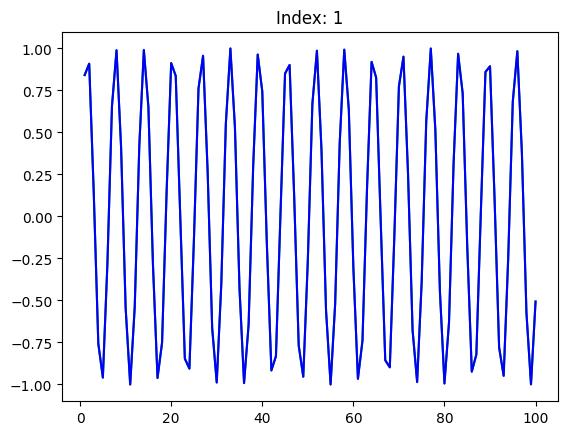

Target:  cos x
Best solution cos x
Best fitness -0.0002


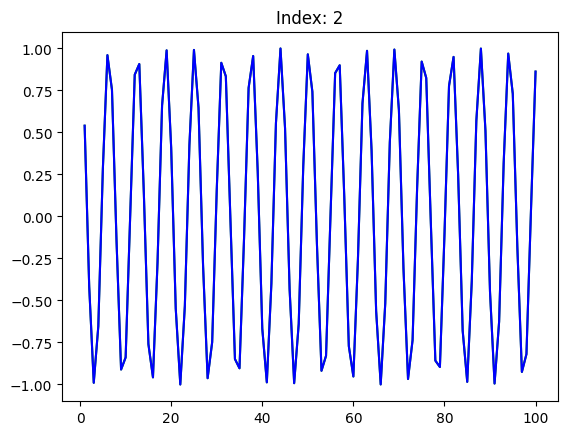

Target:  exp x
Best solution exp x
Best fitness -0.0002


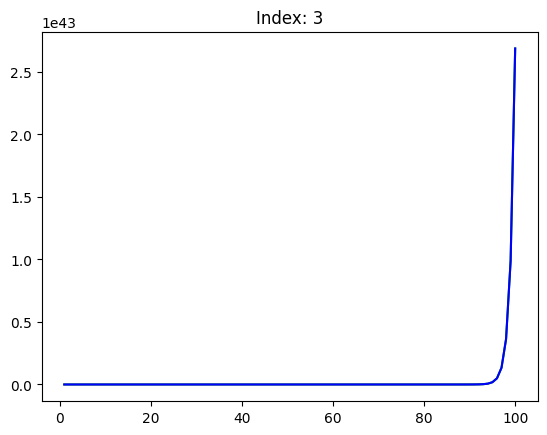

Target:  log x
Best solution log x
Best fitness -0.0002


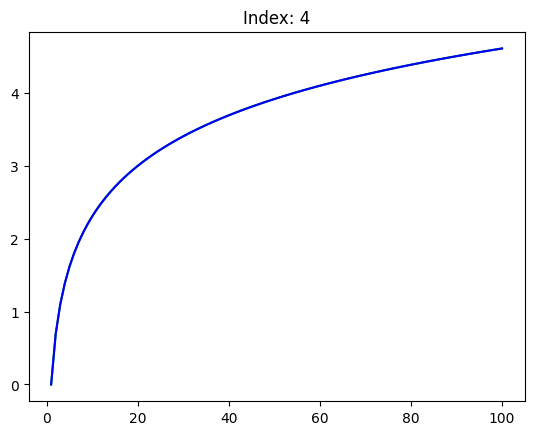

In [3]:
indices = range(1, 6)

graph_predictions(best_models_filename='best_models_custom.pkl', dataset_filename='custom_dataset.csv', indices=indices)